# Example usage of the ofset free koopman MPC

In [191]:
import sys
import os
import numpy as np
#import pandas as pd
import joblib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
from sklearn.preprocessing import StandardScaler

from neuromancer.system import Node, System
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer. modules import blocks

# Add 'src' to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
sys.path.append(src_path)

import models
import helper
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Creating a Dataset

In [192]:
# Instantiate CSTR series with recycle model
CSTR = models.CSTRSeriesRecycle()

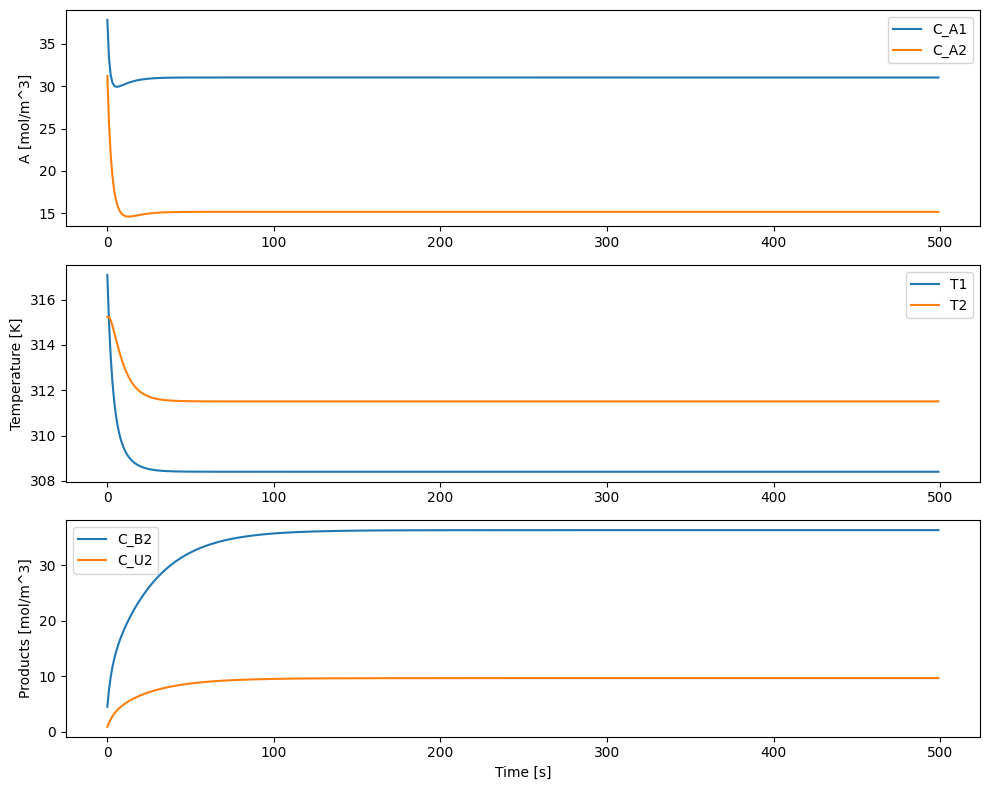

In [193]:
# example simulation
sim_time = 500
Ts = 1
# initial states [C_A1, T1, C_A2, T2, C_B1, C_B2, C_U1, C_U2]
C_A1_0, T1_0, C_A2_0, T2_0 = 50.0, 320.0, 40.0, 315.0
C_B1_0, C_B2_0, C_U1_0, C_U2_0 = 0.0, 0.0, 0.0, 0.0
x0 = [C_A1_0, T1_0, C_A2_0, T2_0, C_B1_0, C_B2_0, C_U1_0, C_U2_0]
# inputs [F, L, Tc1, Tc2]
u = np.ones((sim_time, 4))
u[:, 0] = 1e-4   # F
u[:, 1] = 1e-4   # L
u[:, 2] = 315.0  # Tc1
u[:, 3] = 315.0  # Tc2

sim = CSTR.simulate(x0, u, Ts)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(sim['Y'][:, 0], label='C_A1')
plt.plot(sim['Y'][:, 2], label='C_A2')
plt.ylabel('A [mol/m^3]')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(sim['Y'][:, 1], label='T1')
plt.plot(sim['Y'][:, 3], label='T2')
plt.ylabel('Temperature [K]')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(sim['Y'][:, 5], label='C_B2')
plt.plot(sim['Y'][:, 7], label='C_U2')
plt.ylabel('Products [mol/m^3]')
plt.xlabel('Time [s]')
plt.legend()

plt.tight_layout()
plt.show()


In [194]:
import scipy.optimize

def find_steady_state(model, u, x0=None, tol=1e-8, maxiter=1000):
    """
    Finds the steady state x_ss for the given model and constant input u.
    
    Parameters
    ----------
    model : Model instance
        The dynamic model (must have .ode(t, x) and .Ts attributes).
    u : array-like
        Constant input vector for which to find the steady state.
    x0 : array-like or None
        Initial guess for the state. If None, uses default near-feed guess.
    tol : float
        Tolerance for the steady-state solver.
    maxiter : int
        Maximum number of iterations for the solver.
        
    Returns
    -------
    x_ss : np.ndarray
        Steady-state state vector.
    """
    # Set the model's input data to a constant input
    model.u_data = np.atleast_2d(u)
    model.Ts = 1.0  # dummy sampling time for get_input

    # State dimension: use model by simulating one step from a guess
    if x0 is None:
        # default initial guess close to feed, zeros for products
        x0 = np.array([model.C_A_O, model.T_O, model.C_A_O, model.T_O, 0.0, 0.0, 0.0, 0.0], dtype=float)
    
    def residual(x):
        # ODE at steady state: dx/dt = 0
        return np.array(model.ode(0, x))
    
    sol = scipy.optimize.root(residual, x0, method='hybr', tol=tol, options={'maxfev': maxiter})
    if not sol.success:
        print("Warning: Steady-state solver did not converge:", sol.message)
    return sol.x

# Example usage:
steady_u = [1e-4, 1e-4, 300.0, 300.0]  # [F, L, Tc1, Tc2]
x_ss = find_steady_state(CSTR, steady_u)
print("Steady-state x:", x_ss)


Steady-state x: [ 38.38272973 299.09381862  22.57988549 299.46534065  27.74578153
  34.9642864    3.60788816   4.97372266]


### Step changes and simulation

In [195]:
# constraints for inputs [F, L, Tc1, Tc2]
constraints = np.array([
    [0, 2e-4],   # F range [m^3/s]
    [0, 2e-4],   # L range [m^3/s]
    [280.0, 330.0], # Tc1 [K]
    [280.0, 330.0], # Tc2 [K]
])
step_time = 100
no_steps = 100
steps = helper.generate_steps(step_time, no_steps, constraints)

In [196]:
Ts = 1
# initial states [C_A1, T1, C_A2, T2, C_B1, C_B2, C_U1, C_U2]
C_A1_0, T1_0, C_A2_0, T2_0 = 50.0, 320.0, 40.0, 315.0
C_B1_0, C_B2_0, C_U1_0, C_U2_0 = 0.0, 0.0, 0.0, 0.0
x0 = [C_A1_0, T1_0, C_A2_0, T2_0, C_B1_0, C_B2_0, C_U1_0, C_U2_0]

sim = CSTR.simulate(x0, steps, Ts)

In [197]:
# add noise to sim data

add_noise = False
if add_noise:
    # add noise to the simulation data
    # set random seed for reproducibility
    np.random.seed(42)
    noise = np.random.normal(0, 0.02, sim["Y"].shape)
    sim["Y"] += noise

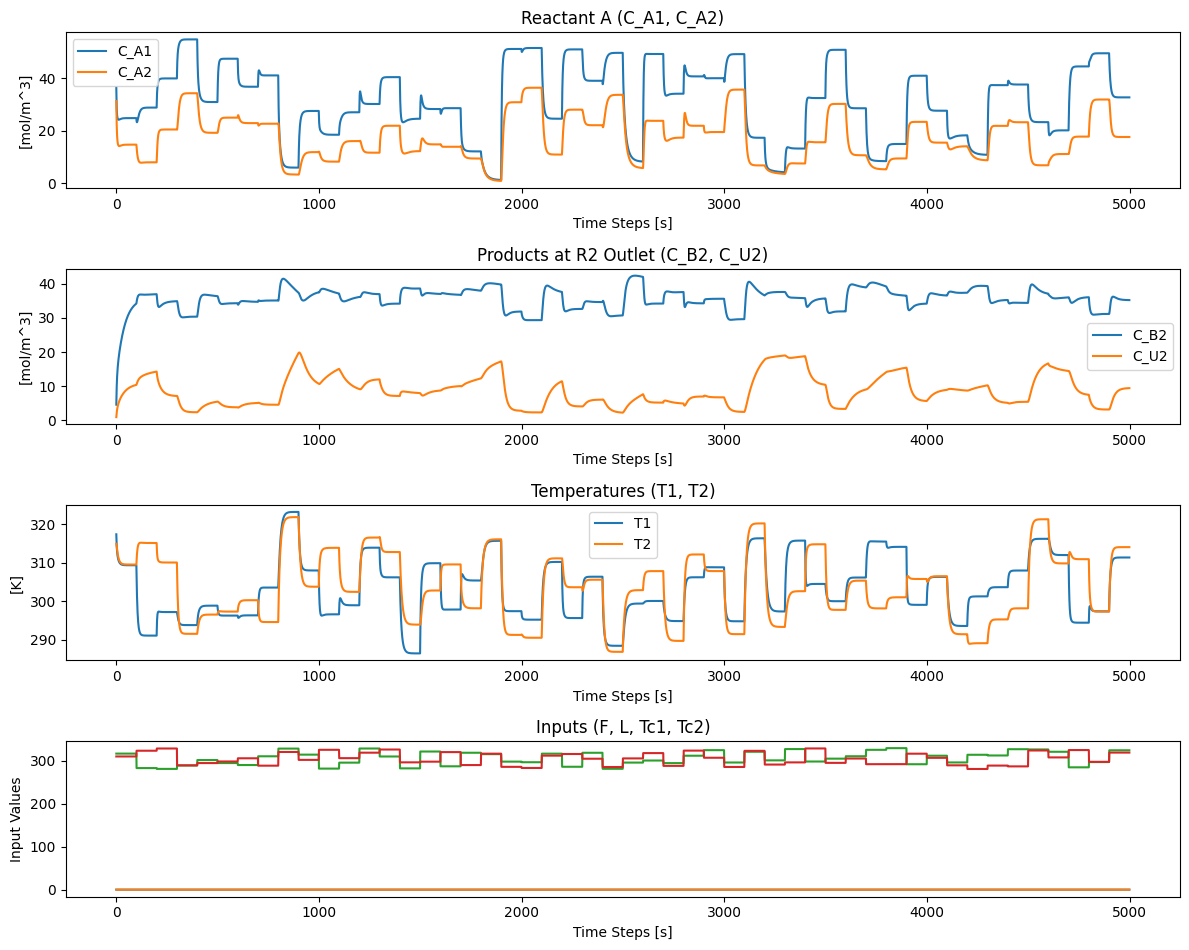

In [198]:
part = 5000

plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(sim["Y"][:part, [0, 2]], label=["C_A1", "C_A2"])
plt.title("Reactant A (C_A1, C_A2)")
plt.xlabel("Time Steps [s]")
plt.ylabel("[mol/m^3]")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(sim["Y"][:part, [5, 7]], label=["C_B2", "C_U2"])
plt.title("Products at R2 Outlet (C_B2, C_U2)")
plt.xlabel("Time Steps [s]")
plt.ylabel("[mol/m^3]")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(sim["Y"][:part, [1, 3]], label=["T1", "T2"])
plt.title("Temperatures (T1, T2)")
plt.xlabel("Time Steps [s]")
plt.ylabel("[K]")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(sim["U"][:part])
plt.title("Inputs (F, L, Tc1, Tc2)")
plt.xlabel("Time Steps [s]")
plt.ylabel("Input Values")

plt.tight_layout(rect=[0, 0, 1, 0.96])

## Preparing data for training koopman models

In [199]:
def get_data(train_sim, dev_sim, test_sim, nsteps, bs, scaler, scalerU):
    
    ny = train_sim['Y'].shape[1]
    nu = train_sim['U'].shape[1]
    
    nsim = train_sim['Y'].shape[0]
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    trainX = scaler.transform(train_sim['Y'][:length])
    trainX = trainX.reshape(nbatch, nsteps, ny)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU = scalerU.transform(train_sim['U'][:length])
    trainU = trainU.reshape(nbatch, nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    train_data = DictDataset({'Y': trainX, 'Y0': trainX[:, 0:1, :],
                              'U': trainU}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)
    
    nsim = dev_sim['Y'].shape[0]
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps
    
    devX = scaler.transform(dev_sim['Y'][:length])
    devX = devX.reshape(nbatch, nsteps, ny)
    devX = torch.tensor(devX, dtype=torch.float32)
    devU = scalerU.transform(dev_sim['U'][:length])
    devU = devU[:length].reshape(nbatch, nsteps, nu)
    devU = torch.tensor(devU, dtype=torch.float32)
    dev_data = DictDataset({'Y': devX, 'Y0': devX[:, 0:1, :],
                            'U': devU}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    nsim = test_sim['Y'].shape[0]
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps
    
    testX = scaler.transform(test_sim['Y'][:length])
    testX = testX.reshape(1, nbatch*nsteps, ny)
    testX = torch.tensor(testX, dtype=torch.float32)
    testU = scalerU.transform(test_sim['U'][:length])
    testU = testU.reshape(1, nbatch*nsteps, nu)
    testU = torch.tensor(testU, dtype=torch.float32)
    test_data = {'Y': testX, 'Y0': testX[:, 0:1, :],
                 'U': testU}
    
    trainX = scaler.transform(train_sim['Y'][:length])
    trainX = trainX.reshape(1, nbatch*nsteps, ny)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU = scalerU.transform(train_sim['U'][:length])
    trainU = trainU.reshape(1, nbatch*nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    train_data_forC = {'Y': trainX, 'Y0': trainX[:, 0:1, :],
                 'U': trainU}

    return train_loader, dev_loader, test_data, train_data_forC

In [200]:
train_sim = {key: value[:5000] for key, value in sim.items()}
test_sim = {key: value[7000:] for key, value in sim.items()}
dev_sim = {key: value[5000:7000] for key, value in sim.items()}

nsteps = 80   # number of prediction horizon steps in the loss function
bs = 80      # minibatching batch size

In [201]:
# fit and save scalers for scaling the data on train dataset
scaler = StandardScaler()
scaler.fit(train_sim['Y'])  
joblib.dump(scaler, '../data/scaler.pkl')

scalerU = StandardScaler()
scalerU.fit(train_sim['U'])
joblib.dump(scalerU, '../data/scalerU.pkl')


['../data/scalerU.pkl']

In [202]:
train_loader, dev_loader, test_data, train_data = get_data(train_sim, dev_sim, test_sim, nsteps, bs, scaler, scalerU)

## Creating the model


In [203]:
# model parameters
nz = 22
ny = train_sim['Y'].shape[1]
nu = train_sim['U'].shape[1]

layers = [40,80,120]
layers_dec  = [120,80,40]

matrix_C = False

In [204]:
# instantiate output encoder neural net f_y
f_y = blocks.MLP(
    ny,
    nz,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ReLU,
    hsizes=layers,
)
# initial condition encoder
encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
# observed trajectory encoder
encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

In [205]:
# instantiate input encoder net f_u, representing the B matrix in the linear system
f_u = torch.nn.Linear(nu, nz, bias=False)
# initial condition encoder
encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

In [206]:
# instantiate state decoder neural net f_y_inv
if not matrix_C:
    f_y_inv = blocks.MLP(nz, ny, bias=True,
                    linear_map=torch.nn.Linear,
                    nonlin=torch.nn.ELU,
                    hsizes=layers_dec)
elif matrix_C:
    f_y_inv = torch.nn.Linear(nz, ny, bias=False)
else:
    raise ValueError('matrix_C must be boolean')

# predicted trajectory decoder
decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

In [207]:
# representing matrix A in the linear system
K = torch.nn.Linear(nz, nz, bias=False)

In [208]:
# symbolic Koopman model with control inputs
Koopman = Node(helper.PredictionWControl(K), ['x', 'u_latent'], ['x'], name='K')

# latent Koopmann rollout
dynamics_model = System([Koopman], name='Koopman', nsteps=nsteps)

In [209]:
# put all nodes of the Koopman model together in a list of nodes
nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]

### Define Koopman system identification loss function terms

In [210]:
# variables
Y = variable("Y")  # observed
yhat = variable('yhat')  # predicted output
x_latent = variable('x_latent')  # encoded output trajectory in the latent space
u_latent = variable('u_latent')  # encoded input trajectory in the latent space
x = variable('x')  # Koopman latent space trajectory

xu_latent = x_latent + u_latent  # latent state trajectory

# output trajectory tracking loss
y_loss = 10. * (yhat[:, 1:-1, :] == Y[:, 1:, :]) ^ 2
y_loss.name = "y_loss"

# one-step tracking loss
onestep_loss = 1.*(yhat[:, 1, :] == Y[:, 1, :])^2
onestep_loss.name = "onestep_loss"

# reconstruction loss
reconstruction_loss = 20.*(yhat[:, 0, :] == Y[:, 0, :])^2
reconstruction_loss.name = "reconstruction_loss"

# latent trajectory tracking loss
x_loss = 1. * (x[:, 1:-1, :] == xu_latent[:, 1:, :]) ^ 2
x_loss.name = "x_loss"

### Construct System learning problem

In [211]:
# aggregate list of objective terms and constraints
objectives = [y_loss, x_loss, onestep_loss, reconstruction_loss]

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints=[])

# construct constrained optimization problem
problem = Problem(nodes, loss)

In [212]:
problem.nodes

ModuleList(
  (0): encoder_Y0(Y0) -> x
  (1): encoder_Y(Y) -> x_latent
  (2): encoder_U(U) -> u_latent
  (3): System(
    (nodes): ModuleList(
      (0): K(x, u_latent) -> x
    )
  )
  (4): decoder_y(x) -> yhat
)

### Solve the problem

In [213]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=400,
    warmup=500,
    epochs=5000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
)


In [214]:
# train

best_model = trainer.train()
problem.load_state_dict(best_model)


epoch: 0  train_loss: 35.7099609375
epoch: 1  train_loss: 35.13134765625
epoch: 2  train_loss: 34.564117431640625
epoch: 3  train_loss: 33.982826232910156
epoch: 4  train_loss: 33.36467361450195
epoch: 5  train_loss: 32.688690185546875
epoch: 6  train_loss: 31.934879302978516
epoch: 7  train_loss: 31.083866119384766
epoch: 8  train_loss: 30.11762237548828
epoch: 9  train_loss: 29.020999908447266
epoch: 10  train_loss: 27.78256607055664
epoch: 11  train_loss: 26.39826202392578
epoch: 12  train_loss: 24.8798885345459
epoch: 13  train_loss: 23.25139808654785
epoch: 14  train_loss: 21.561277389526367
epoch: 15  train_loss: 19.879623413085938
epoch: 16  train_loss: 18.29141616821289
epoch: 17  train_loss: 16.88322639465332
epoch: 18  train_loss: 15.720685958862305
epoch: 19  train_loss: 14.83419418334961
epoch: 20  train_loss: 14.230056762695312
epoch: 21  train_loss: 13.899391174316406
epoch: 22  train_loss: 13.786118507385254
epoch: 23  train_loss: 13.72580337524414
epoch: 24  train_loss:

<All keys matched successfully>

### Saving model and evaluation of the training

In [215]:
# save model
torch.save(best_model, "../data/model_C_" + str(matrix_C) + ".pth")

# pull matrices
A = K.weight.detach().numpy()
B = f_u.weight.detach().numpy()
if matrix_C:
    C = f_y_inv.weight.detach().numpy()
    
elif not matrix_C:
    # get approximate C matrix from training data
    problem.nodes[3].nsteps = train_data['Y'].shape[1]
    train_outputs = problem.step(train_data)

    Y = train_data['Y'].reshape(-1, ny).detach().numpy()
    Z = train_outputs['x'][:,:-1,:].detach().numpy().reshape(-1, nz)
    rankZ = np.linalg.matrix_rank(Z)
    if rankZ < nz:
        print('Rank deficient Z matrix, can result in bad fitted C matrix!')
    C, residuals, rank, s = np.linalg.lstsq(Z, Y, rcond=None)
    C = C.T
    
    # get approximate C matrix with constant term from training data
    Z_with_const = np.hstack([Z, np.ones((Z.shape[0], 1))])
    rankZ_const = np.linalg.matrix_rank(Z_with_const)
    if rankZ_const < nz + 1:
        print('Rank deficient Z_with_const matrix, can result in bad fitted C_const matrix!')
    C_with_const, residuals_const, rank_const, s_const = np.linalg.lstsq(Z_with_const, Y, rcond=None)
    C_const = C_with_const.T  # shape: (ny, nz+1), last column is the constant term

else:
    raise ValueError('matrix_C must be boolean')

In [216]:
# Calculate and print the rank of the Z matrix
print("Rank of Z matrix:", np.linalg.matrix_rank(Z))


Rank of Z matrix: 22


In [217]:
C

array([[-3.2544956 , -3.3718326 , -0.37280828,  0.56011206,  0.76335716,
        -0.23174267, -3.389545  , -0.30381402, -3.379549  , -4.008522  ,
        -2.924966  ,  2.449955  ,  3.9608617 , -2.243299  , -1.4350209 ,
        -1.3712472 ,  1.7817076 , -1.6281269 , -1.946734  ,  3.0197701 ,
         2.6752763 , -0.22088948],
       [ 3.3890908 ,  4.3821254 , -0.16223894, -0.8205814 ,  0.42957112,
         0.6545027 ,  3.7029321 ,  0.5204558 ,  4.624773  ,  3.6959455 ,
         2.4287305 , -3.1975198 , -5.0061116 ,  2.524661  ,  1.9197437 ,
         1.3308243 , -2.772257  ,  2.4040864 ,  1.8553549 , -3.605636  ,
        -2.7224524 ,  0.56759185],
       [-3.506091  , -3.5386596 , -0.35999867,  0.41963828,  3.2956579 ,
         1.0642906 , -3.8515694 , -1.1500244 , -3.4040246 , -5.379141  ,
        -4.0412464 ,  2.688268  ,  3.704923  , -3.5708523 , -0.9891947 ,
        -2.2304676 ,  2.6227489 , -2.394668  , -2.722957  ,  2.3446288 ,
         3.0401914 ,  0.4571194 ],
       [ 1.7502656 

In [218]:
C_const[:,1]

array([-3.32340323,  4.41702665, -3.48853334,  7.14677302,  0.6928354 ,
       -2.57141501,  0.53998663,  0.44790707])

In [219]:
from numpy.linalg import matrix_rank

# Compute the controllability matrix
n_states = A.shape[0]
controllability_matrix = np.hstack([np.linalg.matrix_power(A, i) @ B for i in range(n_states)])

# Check the rank of the controllability matrix
controllability_rank = matrix_rank(controllability_matrix)

print(f"Controllability Matrix Rank: {controllability_rank}")
print(f"System is {'controllable' if controllability_rank == n_states else 'not controllable'}")

Controllability Matrix Rank: 22
System is controllable


In [220]:
# # Evaluate Jacobian for each latent state
# J_all = np.stack([
#     helper.evaluate_jacobian(problem.nodes[4], torch.from_numpy(xi).float())
#     for xi in x_train
# ])

# # Compute mean Jacobian
# C = np.mean(J_all, axis=0)
# print("Mean Jacobian J_mean:\n", C) # mean bias?

In [221]:
np.save('../data/A_C_' + str(matrix_C) + '.npy', A)
np.save('../data/B_C_' + str(matrix_C) + '.npy', B)
np.save('../data/C_C_' + str(matrix_C) + '.npy', C)
np.save('../data/C_const_C_' + str(matrix_C) + '.npy', C_const)

In [222]:
# update the rollout length based on the test data
problem.nodes[3].nsteps = test_data['Y'].shape[1]

In [223]:
# do the prediction
test_outputs = problem.step(test_data)

pred_traj = test_outputs['yhat'][:, 1:-1, :].detach().numpy().reshape(-1, ny).T
true_traj = test_data['Y'][:, 1:pred_traj.shape[1]+1, ].detach().numpy().reshape(-1, ny).T
input_traj = test_data['U'].detach().numpy().reshape(-1, nu).T
pred_x = test_outputs['x'][:, 1:-1, :].detach().numpy().reshape(-1, nz).T

In [224]:
pred_traj_C = np.dot(C, pred_x)

# Calculate prediction using C_const (C_matrix + constant)
# C_const has shape (ny, nz+1), where last column is constant term
C_matrix = C_const[:, :-1]  # shape: (ny, nz)
C_constant = C_const[:, -1]  # shape: (ny,)
pred_traj_C_const = np.dot(C_matrix, pred_x) + C_constant.reshape(-1, 1)  # y = C_matrix @ x + constant

In [225]:
x_mean = np.mean(pred_x, axis=1, keepdims=True)
x_med = np.median(pred_x, axis=1, keepdims=True)

In [226]:
def get_y_from_x(problem, x: np.ndarray) -> np.ndarray:
    y = problem.nodes[4]({"x": torch.from_numpy(x.T).float()})
    return y["yhat"].detach().numpy().reshape(1, -1)

In [227]:
J = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(x_mean[:,0]).float(),
)
# Get all latent states from training data
x_train = train_outputs['x'].detach().numpy().reshape(-1, nz)

# Evaluate Jacobian for each latent state
J_all = np.stack([
    helper.evaluate_jacobian(problem.nodes[4], torch.from_numpy(xi).float())
    for xi in x_train
])

bias_all = np.stack([
    get_y_from_x(problem, xi.reshape(-1,1))
    for xi in x_train
])

# Compute mean Jacobian
J_mean = np.mean(J_all, axis=0)
print("Mean Jacobian J_mean:\n", J_mean) # mean bias?

bias_mean = np.mean(bias_all, axis=0)
print("Mean Bias:\n", bias_mean)


pred_traj_J = np.dot(J_mean, pred_x - x_mean) + bias_mean.T

Mean Jacobian J_mean:
 [[-9.20904353e-02  4.27383035e-01 -9.22960415e-02  3.19361724e-02
   3.35797071e-01  5.50837934e-01 -1.91993162e-01  2.42844194e-01
  -3.01295310e-01 -1.60216346e-01 -3.00526619e-01  1.36698827e-01
  -4.93999803e-04 -2.38371789e-01  1.09374814e-01  1.31086949e-02
  -2.51438797e-01 -5.78724593e-02  4.19530094e-01  2.68941492e-01
   6.40851706e-02 -3.90306681e-01]
 [ 1.13082193e-01 -2.19332993e-01 -4.31321532e-01 -6.66930005e-02
  -1.75264940e-01 -3.07516605e-01  3.84863049e-01 -4.51911509e-01
   3.87124449e-01 -3.13888639e-01 -5.56201562e-02 -8.87943387e-01
   1.31504446e-01 -4.52182293e-02  1.60968915e-01 -1.87655449e-01
  -1.37450591e-01 -2.69659698e-01  1.67361692e-01 -4.24704850e-01
   1.02094293e-01  1.08567908e-01]
 [ 3.93611133e-01  5.53857647e-02 -1.50730848e-01 -2.22104236e-01
   4.48951483e-01  4.60419089e-01  7.63975680e-02  2.98803061e-01
  -3.37936789e-01 -1.89061105e-01 -3.00615400e-01  1.10287540e-01
  -2.68253744e-01 -2.31428117e-01  3.80764872e-01

In [228]:
x_lin = np.zeros((nz,1))
J = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(x_lin[:,0]).float(),
)

bias = get_y_from_x(problem, x_lin)
pred_traj_J = np.dot(J, pred_x - x_lin) + bias.T

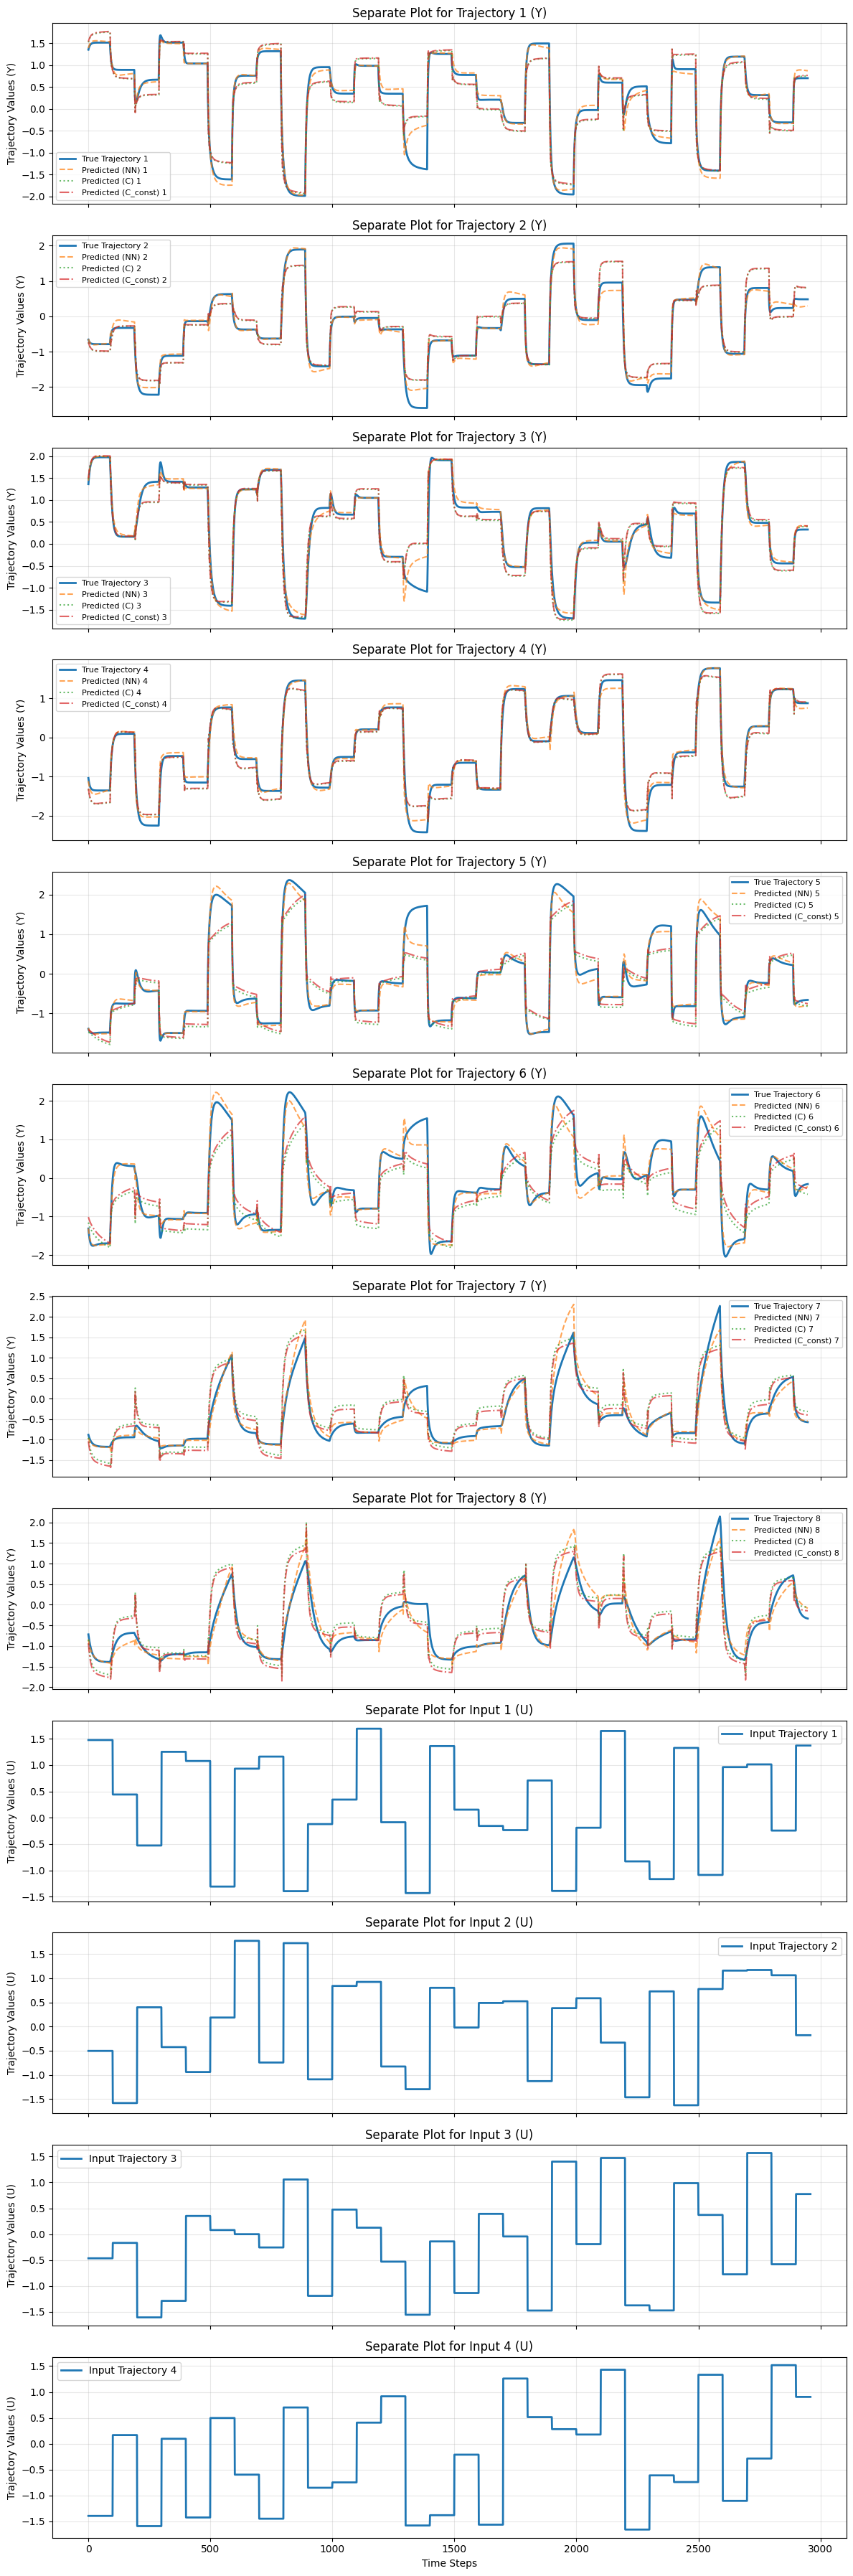

In [229]:
fig, axs = plt.subplots(ny + nu, 1, figsize=(12, 3 * (ny + nu)), sharex=True)

# Separate plots for each vector in Y
for i in range(ny):
    axs[i].plot(true_traj[i][10:], label=f'True Trajectory {i + 1}', linestyle='-', linewidth=2)
    axs[i].plot(pred_traj[i][10:], label=f'Predicted (NN) {i + 1}', linestyle='--', alpha=0.7)
    axs[i].plot(pred_traj_C[i][10:], label=f'Predicted (C) {i + 1}', linestyle=':', alpha=0.7)
    axs[i].plot(pred_traj_C_const[i][10:], label=f'Predicted (C_const) {i + 1}', linestyle='-.', alpha=0.7)
    #axs[i].plot(pred_traj_J[i], label=f'Predicted Trajectory {i + 1} J', linestyle='--')
    axs[i].set_title(f'Separate Plot for Trajectory {i + 1} (Y)')
    axs[i].legend(fontsize=8)
    axs[i].grid(True, alpha=0.3)

# Separate plots for each vector in U
for i in range(nu):
    axs[ny + i].plot(input_traj[i], label=f'Input Trajectory {i + 1}', linestyle='-', linewidth=2)
    axs[ny + i].set_title(f'Separate Plot for Input {i + 1} (U)')
    axs[ny + i].legend()
    axs[ny + i].grid(True, alpha=0.3)

# Add labels
axs[-1].set_xlabel('Time Steps')
for i in range(ny):
    axs[i].set_ylabel('Trajectory Values (Y)')
for i in range(nu):
    axs[ny + i].set_ylabel('Trajectory Values (U)')

plt.tight_layout()
plt.show()


In [230]:
# calculate MAE of predicted trajectories
mae_pred = np.mean(np.abs(true_traj - pred_traj), axis=1)
mae_pred_C = np.mean(np.abs(true_traj - pred_traj_C), axis=1)
mae_pred_C_const = np.mean(np.abs(true_traj - pred_traj_C_const), axis=1)
mae_pred_J = np.mean(np.abs(true_traj - pred_traj_J), axis=1)

print(f'MAE of predicted trajectory (NN): {sum(mae_pred):.6f}')
print(f'MAE of predicted trajectory C: {sum(mae_pred_C):.6f}')
print(f'MAE of predicted trajectory C_const: {sum(mae_pred_C_const):.6f}')
print(f'MAE of predicted trajectory J: {sum(mae_pred_J):.6f}')

# Print per-output MAE for better comparison
print('\nPer-output MAE:')
print(f'  NN:    {mae_pred}')
print(f'  C:     {mae_pred_C}')
print(f'  C_const: {mae_pred_C_const}')
print(f'  J:     {mae_pred_J}')

MAE of predicted trajectory (NN): 0.943442
MAE of predicted trajectory C: 2.096140
MAE of predicted trajectory C_const: 1.981732
MAE of predicted trajectory J: 2.781977

Per-output MAE:
  NN:    [0.09531428 0.10033351 0.08481009 0.0871962  0.12362119 0.1517159
 0.12945262 0.1709986 ]
  C:     [0.21342061 0.23687975 0.15619427 0.15765004 0.29195106 0.41847798
 0.3090453  0.31252134]
  C_const: [0.21261722 0.23876636 0.15564132 0.15416836 0.28084785 0.37456684
 0.27729897 0.28782477]
  J:     [0.37207374 0.27991445 0.31620852 0.26373383 0.37963119 0.3830923
 0.35769466 0.42962864]


In [231]:
# MAE of predicted trajectory: 0.9612109661102295
# MAE of predicted trajectory C: 1.8843942880630493

In [232]:
# Define lower and upper bounds for true_traj values
lower_bound = -0.01
upper_bound = 0.01

# Create mask for values within the specified range
mask = (true_traj >= lower_bound) & (true_traj <= upper_bound)

# Compute MAE only for masked values
mae_pred_masked = [np.mean(np.abs(true_traj[i][mask[i]] - pred_traj[i][mask[i]])) for i in range(true_traj.shape[0])]
mae_pred_C_masked = [np.mean(np.abs(true_traj[i][mask[i]] - pred_traj_C[i][mask[i]])) for i in range(true_traj.shape[0])]
mae_pred_C_const_masked = [np.mean(np.abs(true_traj[i][mask[i]] - pred_traj_C_const[i][mask[i]])) for i in range(true_traj.shape[0])]
mae_pred_J_masked = [np.mean(np.abs(true_traj[i][mask[i]] - pred_traj_J[i][mask[i]])) for i in range(true_traj.shape[0])]

print(f'Masked MAE of predicted trajectory (NN): {sum(mae_pred_masked):.6f}')
print(f'Masked MAE of predicted trajectory C: {sum(mae_pred_C_masked):.6f}')
print(f'Masked MAE of predicted trajectory C_const: {sum(mae_pred_C_const_masked):.6f}')
print(f'Masked MAE of predicted trajectory J: {sum(mae_pred_J_masked):.6f}')

Masked MAE of predicted trajectory (NN): 1.227891
Masked MAE of predicted trajectory C: 2.006624
Masked MAE of predicted trajectory C_const: 1.912455
Masked MAE of predicted trajectory J: 1.907420


In [233]:
J_mean

array([[-9.20904353e-02,  4.27383035e-01, -9.22960415e-02,
         3.19361724e-02,  3.35797071e-01,  5.50837934e-01,
        -1.91993162e-01,  2.42844194e-01, -3.01295310e-01,
        -1.60216346e-01, -3.00526619e-01,  1.36698827e-01,
        -4.93999803e-04, -2.38371789e-01,  1.09374814e-01,
         1.31086949e-02, -2.51438797e-01, -5.78724593e-02,
         4.19530094e-01,  2.68941492e-01,  6.40851706e-02,
        -3.90306681e-01],
       [ 1.13082193e-01, -2.19332993e-01, -4.31321532e-01,
        -6.66930005e-02, -1.75264940e-01, -3.07516605e-01,
         3.84863049e-01, -4.51911509e-01,  3.87124449e-01,
        -3.13888639e-01, -5.56201562e-02, -8.87943387e-01,
         1.31504446e-01, -4.52182293e-02,  1.60968915e-01,
        -1.87655449e-01, -1.37450591e-01, -2.69659698e-01,
         1.67361692e-01, -4.24704850e-01,  1.02094293e-01,
         1.08567908e-01],
       [ 3.93611133e-01,  5.53857647e-02, -1.50730848e-01,
        -2.22104236e-01,  4.48951483e-01,  4.60419089e-01,
    

In [234]:
C

array([[-3.2544956 , -3.3718326 , -0.37280828,  0.56011206,  0.76335716,
        -0.23174267, -3.389545  , -0.30381402, -3.379549  , -4.008522  ,
        -2.924966  ,  2.449955  ,  3.9608617 , -2.243299  , -1.4350209 ,
        -1.3712472 ,  1.7817076 , -1.6281269 , -1.946734  ,  3.0197701 ,
         2.6752763 , -0.22088948],
       [ 3.3890908 ,  4.3821254 , -0.16223894, -0.8205814 ,  0.42957112,
         0.6545027 ,  3.7029321 ,  0.5204558 ,  4.624773  ,  3.6959455 ,
         2.4287305 , -3.1975198 , -5.0061116 ,  2.524661  ,  1.9197437 ,
         1.3308243 , -2.772257  ,  2.4040864 ,  1.8553549 , -3.605636  ,
        -2.7224524 ,  0.56759185],
       [-3.506091  , -3.5386596 , -0.35999867,  0.41963828,  3.2956579 ,
         1.0642906 , -3.8515694 , -1.1500244 , -3.4040246 , -5.379141  ,
        -4.0412464 ,  2.688268  ,  3.704923  , -3.5708523 , -0.9891947 ,
        -2.2304676 ,  2.6227489 , -2.394668  , -2.722957  ,  2.3446288 ,
         3.0401914 ,  0.4571194 ],
       [ 1.7502656 

In [235]:
# mse C-J
mse_C_J = np.mean((C - J_mean) ** 2)
print("Mean Squared Error between C and J_mean:\n", mse_C_J)
# mse C-J
mse_C_J = np.mean((C - J) ** 2)
print("Mean Squared Error between C and J:\n", mse_C_J)

Mean Squared Error between C and J_mean:
 7.776748
Mean Squared Error between C and J:
 7.7949677


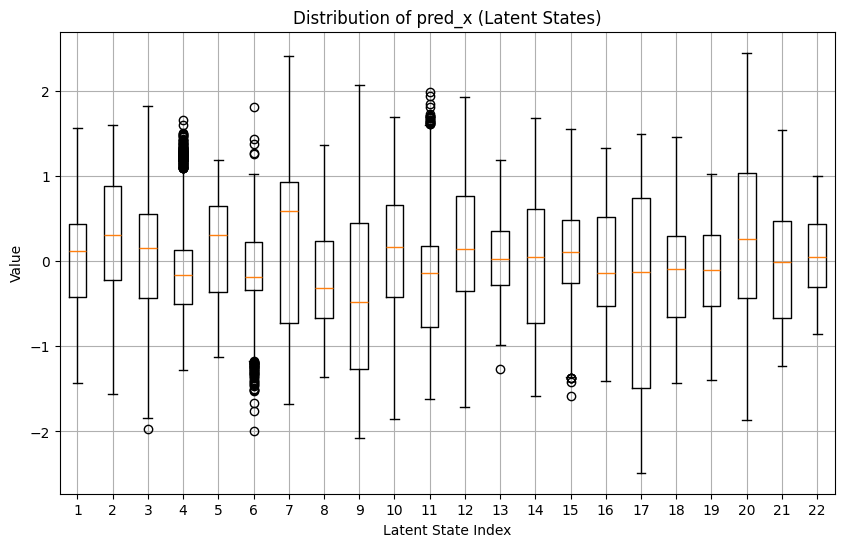

In [236]:
plt.figure(figsize=(10, 6))
plt.boxplot(pred_x.T)
plt.title('Distribution of pred_x (Latent States)')
plt.xlabel('Latent State Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

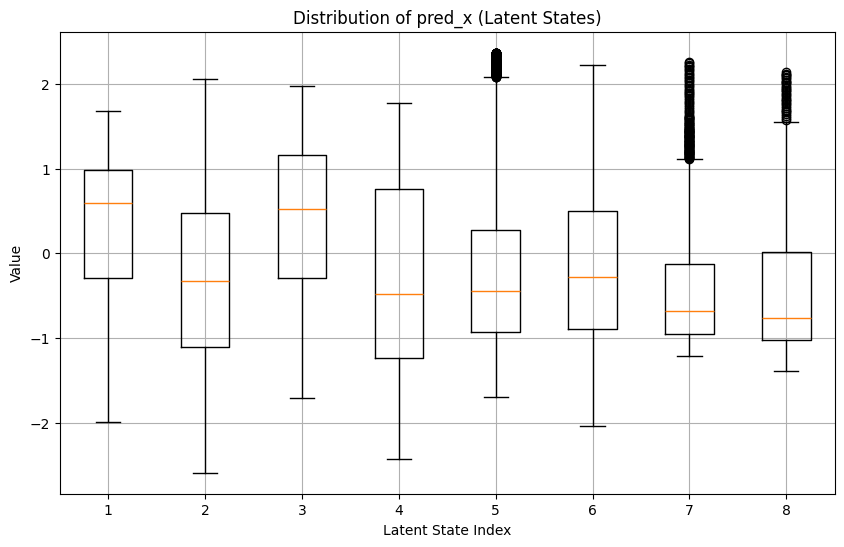

In [237]:
plt.figure(figsize=(10, 6))
plt.boxplot(true_traj.T)
plt.title('Distribution of pred_x (Latent States)')
plt.xlabel('Latent State Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [238]:

true_traj_descaled = scaler.inverse_transform(true_traj.T)
for i in range(8):
    min_true_traj_descaled = np.min(true_traj_descaled[:,i])
    max_true_traj_descaled = np.max(true_traj_descaled[:,i])
    print(f"Descaled min of true_traj {i}:", min_true_traj_descaled)
    print(f"Descaled max of true_traj {i}:", max_true_traj_descaled)


Descaled min of true_traj 0: 3.7700365
Descaled max of true_traj 0: 54.478035
Descaled min of true_traj 1: 282.57596
Descaled max of true_traj 1: 319.5093
Descaled min of true_traj 2: 2.5636313
Descaled max of true_traj 2: 34.511612
Descaled min of true_traj 3: 282.0993
Descaled max of true_traj 3: 319.3196
Descaled min of true_traj 4: 20.690596
Descaled max of true_traj 4: 42.07516
Descaled min of true_traj 5: 29.117628
Descaled max of true_traj 5: 42.61236
Descaled min of true_traj 6: 1.5366039
Descaled max of true_traj 6: 16.612625
Descaled min of true_traj 7: 2.4926567
Descaled max of true_traj 7: 18.056665
